<a href="https://colab.research.google.com/github/asifahmed90/Time-Series-Analysis/blob/master/Cryptocurrency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing Bidirectional LSTM and GRU model for Time Series Analysis


Load the necessary Library in your notebook.

In [0]:
from tensorflow.python.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM,GRU
 
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
 
from sklearn.preprocessing import MinMaxScaler
 
from datetime import date
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

##Dataset Description

We need to upload data before proceeding with the analysis. I used cryptocurrency data from Kaggle. The data can be found here in this [link](https://www.kaggle.com/mczielinski/bitcoin-historical-data).

The dataset presents minute by minute bitcoin prices along with some other factors for the past couple of years. However, there are two datasets, for training and testing. For this initial analysis and tutorial, we will only deal with one dataset to keep it simple. 


In [0]:
from google.colab import files

uploaded = files.upload()

Saving bitstampUSD_1-min_data_2012-01-01_to_2018-11-11_.csv to bitstampUSD_1-min_data_2012-01-01_to_2018-11-11_.csv


Check if the file is uploaded correctly in your local system. In our case, the name of the file is: bitstampUSD_1-min_data_2012-01-01_to_2018-11-11_.csv

In [0]:
!ls

bitstampUSD_1-min_data_2012-01-01_to_2018-11-11_.csv  sample_data


After uploading the dataset, we need to convert the "Timestamp" column into "Date" format. Timestamp are machine generated log file format and can be confusing for us while analyzing the dataset. Instead we can look into the data by considering dates instead of timestamp.
We can use pandas to_datetime to convert the timestamp into date format.

In [0]:
dataset = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-11-11_.csv')


dataset['Date'] = pd.to_datetime(dataset['Timestamp'], unit='s').dt.date
 
group = dataset.groupby('Date') 

#Data cleaning
#dataset.isna().any()


Since we will analyze the data based on time i.e. months and year, we need to set new converted 'Date' column as our primary index. 

In [0]:
#setting index as date

dataset.index = dataset['Date']

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3603136 entries, 2011-12-31 to 2018-11-10
Data columns (total 9 columns):
Timestamp            int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
Date                 object
dtypes: float64(7), int64(1), object(1)
memory usage: 274.9+ MB


Here is the fun part. Lets plot some figure and try to see more closely to our dataset based on dates.

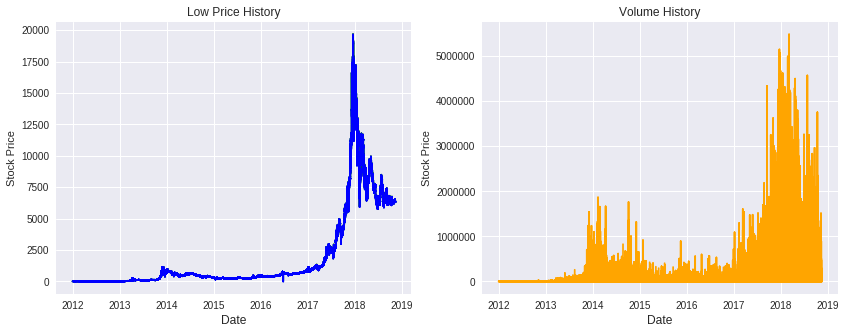

In [0]:
# Simple plotting of Cryptocurrency Price
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(dataset["Date"], dataset["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Price History")

# Second Subplot
ax1.plot(dataset["Date"], dataset["High"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("High Price History")

# Third Subplot
ax1.plot(dataset["Date"], dataset["Low"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Low Price History")

# Fourth Subplot
ax2.plot(dataset["Date"], dataset["Volume_(Currency)"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Volume History")
plt.show()

Now that we have done some initial analysis, we can try to format our data so that it would be easier for us to analyze. We can use MinMaxScaler() to normalize the data between 0 and 1. Normalization help the process to become faster and help understand the network the data better. 

In [0]:
date1 = date(2015, 1, 1)
date2 = date(2018, 6, 25)

day_price = group['Weighted_Price'].mean()
 
delta = date2 - date1
days_look = delta.days + 1
 
data = day_price[len(day_price) - days_look:len(day_price)]
 
scl = MinMaxScaler()
 
data = data.values.reshape(data.shape[0], 1)
scale_data = scl.fit_transform(data)

Next step, we need to split the train and test data and use cross validation over the entire dataset. 

In [0]:
SEQ_LEN = 50
WINDOW_SIZE = SEQ_LEN - 1
 
BATCH_SIZE=64
 
DROPOUT = 0.2
 
 
def load_data(data_raw, seq_len):
    data = []
 
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])
 
    data = np.array(data)
    train_split = 0.8
 
    num_data = data.shape[0]
 
    num_train = int(train_split * num_data)
 
    data = np.array(data);
 
    x_train = data[:num_train, :-1, :]
 
    y_train = data[:num_train, -1, :]
 
    x_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
 
    return [x_train, y_train, x_test, y_test]
 
 
x_train, y_train, x_test, y_test = load_data(scale_data, SEQ_LEN)

##Bidirectional LSTM

We will use a simple bidirectional model in Keras and try to see how it performs. We will use three layers with few nodes to implement the model. For activation function, we will use linear activation and mean square error for loss function. A summary of the entire block has been given below.

We will use EarlyStopping to function in keras which can stop if we get a consistent low loss of the network. 

In [0]:
model = Sequential()
 
# First Layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, x_train.shape[-1])))
model.add(Dropout(DROPOUT))
 
# Second Layer
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(DROPOUT))
 
# Third Layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
 
model.add(Dense(units=1))

# Set activation function
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 49, 98)            19992     
_________________________________________________________________
dropout_34 (Dropout)         (None, 49, 98)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_35 (Dropout)         (None, 49, 196)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 99        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [0]:
history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])


Train on 977 samples, validate on 245 samples
Epoch 1/100
977/977 [==============================] - 23s 24ms/sample - loss: 0.0054 - val_loss: 0.0168
Epoch 2/100
977/977 [==============================] - 11s 12ms/sample - loss: 0.0257 - val_loss: 0.0040
Epoch 3/100
977/977 [==============================] - 12s 12ms/sample - loss: 0.0500 - val_loss: 0.0340
Epoch 4/100
977/977 [==============================] - 11s 12ms/sample - loss: 0.0669 - val_loss: 0.0453
Epoch 5/100
977/977 [==============================] - 12s 12ms/sample - loss: 0.0323 - val_loss: 0.0133
Epoch 6/100
977/977 [==============================] - 12s 12ms/sample - loss: 0.0164 - val_loss: 0.0031
Epoch 7/100
977/977 [==============================] - 11s 12ms/sample - loss: 0.0286 - val_loss: 0.0455
Epoch 8/100
977/977 [==============================] - 11s 12ms/sample - loss: 0.0172 - val_loss: 0.0147
Epoch 9/100
977/977 [==============================] - 11s 12ms/sample - loss: 0.0107 - val_loss: 0.0022
Epoch 10/

The test has been completed with 100 epoch. Now we can plot to see the performance of our model.

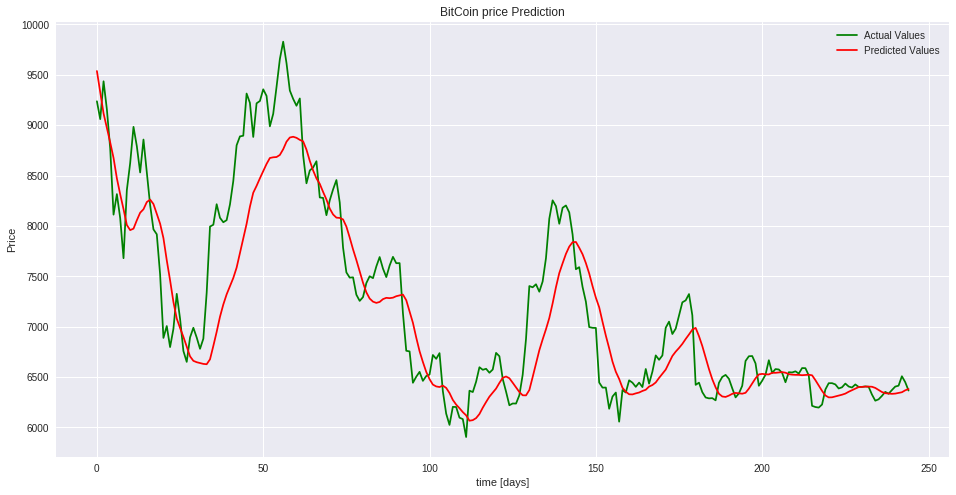

In [0]:
predict_prices = model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='green')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='red')
 
plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

##GRU

Besides LSTM, we will try to evaluate the performace by implementing GRU model on our network. We will try to keep the network simple just as LSTM network and try to analyze the performance.

In [0]:
model_name = 'stock_price_GRU'

model = Sequential()
model.add(GRU(units=100,
              return_sequences=True, 
              input_shape=(WINDOW_SIZE,x_train.shape[-1])))
model.add(Dropout(DROPOUT))
model.add(GRU(units=100))
model.add(Dropout(DROPOUT))
model.add(Dense(1, activation='linear'))
#model.compile(loss='mse', optimizer='adam')

print(model.summary())



# Set activation function
#model.add(Activation('relu')) 
# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_32 (GRU)                 (None, 49, 100)           30600     
_________________________________________________________________
dropout_36 (Dropout)         (None, 49, 100)           0         
_________________________________________________________________
gru_33 (GRU)                 (None, 100)               60300     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 91,001
Trainable params: 91,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 977 samples, validate on 245 samples
Epoch 1/100
977/977 [==============================] - 13s 13ms/sample - loss: 0.0040 -

We can then plot the graph to see the performance of our GRU model. 

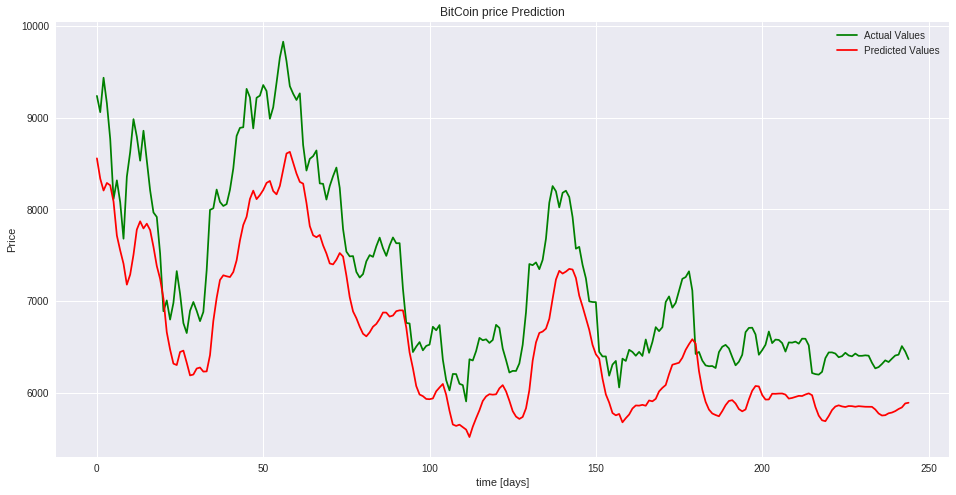

In [0]:
predict_prices = model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='green')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='red')
 
plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

Bidirectional LSTM outperformed the GRU model for the Cryptocurrency Market Analysis.